In [1]:

# Jupyter notebook autoreload
%load_ext autoreload
%autoreload 2

# imports usuels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import plotly.express as px
import geopandas as gpd
import matplotlib.pyplot as plt

# Preprocessing sentences
import string
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist

# Get lat and long of cities
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap

# Dataset Description: "LinkedIn Canada: Data Science Jobs 2024"

Dataset from Kaggle : https://www.kaggle.com/datasets/kanchana1990/linkedin-canada-data-science-jobs-2024

Landscape of data science employment opportunities in Canada at the beginning of 2024 as sourced from LinkedIn.

# Checking the sanity of the database

In [2]:
# Read the csv data of Linkedin opportunities in Canada
data = pd.read_csv("data/linkedin_canada.csv")
data.head()

,applicationsCount,companyId,companyName,contractType,description,experienceLevel,location,postedTime,publishedAt,salary,sector,title,workType
0,Over 200 applicants,11000395.0,Embarq,Full-time,About Embarq\n\nWe help VC-backed US startups ...,Mid-Senior level,"Quebec, Canada",2 weeks ago,2024-01-05,NaN,IT Services and IT Consulting and Software Dev...,Machine Learning Engineer,Engineering and Information Technology
1,Over 200 applicants,912833.0,Thumbtack,Full-time,A home is the biggest investment most people m...,Not Applicable,"Ontario, Canada",2 weeks ago,2024-01-05,NaN,"Technology, Information and Internet","Data Scientist, Business Analytics",Engineering and Information Technology
2,Over 200 applicants,10064814.0,Clarifai,Full-time,"About The Company\n\nClarifai is a leading, fu...",Mid-Senior level,"Montreal, Quebec, Canada",4 months ago,2023-09-15,NaN,"Technology, Information and Internet",Data Scientist,Engineering and Information Technology
3,Over 200 applicants,6637598.0,Drop,Full-time,"As a member of the Data Science team, you are ...",Not Applicable,"Toronto, Ontario, Canada",2 months ago,2023-11-15,NaN,"Transportation, Logistics, Supply Chain and St...","Data Science, Investment Research",Engineering and Information Technology
4,Over 200 applicants,2681218.0,Logikk,Full-time,Data Scientist - Computer Vision Tech Company ...,Mid-Senior level,"Montreal, Quebec, Canada",2 weeks ago,2024-01-05,NaN,IT Services and IT Consulting,Data Scientist,Engineering


In [3]:
#Usual check: shape
data.shape


(275, 13)

In [4]:
#Usual check: columns
data.columns

Index(['applicationsCount', 'companyId', 'companyName', 'contractType',
       'description', 'experienceLevel', 'location', 'postedTime',
       'publishedAt', 'salary', 'sector', 'title', 'workType'],
      dtype='object')

In [5]:
#Usual check: dtypes for each columns and non-null count
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   applicationsCount  275 non-null    object 
 1   companyId          274 non-null    float64
 2   companyName        274 non-null    object 
 3   contractType       264 non-null    object 
 4   description        275 non-null    object 
 5   experienceLevel    275 non-null    object 
 6   location           275 non-null    object 
 7   postedTime         275 non-null    object 
 8   publishedAt        270 non-null    object 
 9   salary             13 non-null     object 
 10  sector             264 non-null    object 
 11  title              275 non-null    object 
 12  workType           264 non-null    object 
dtypes: float64(1), object(12)
memory usage: 28.1+ KB


In [6]:
# TO DO : Need to convert companyID as integer
# data.companyId.astype("int64")

In [7]:
# Checking if there are duplicates
data.duplicated().sum()

0

In [8]:
# Are there any null values:
data.isnull().sum().sort_values(ascending=False)/len(data)


salary               0.952727
contractType         0.040000
sector               0.040000
workType             0.040000
publishedAt          0.018182
companyId            0.003636
companyName          0.003636
applicationsCount    0.000000
description          0.000000
experienceLevel      0.000000
location             0.000000
postedTime           0.000000
title                0.000000
dtype: float64

In [9]:
# 95% of salary is missing data, I prefer to supress it
data_clean = data.drop(columns="salary")

In [10]:
# Location columns readability can be improved
data_clean.location.unique()

array(['Quebec, Canada', 'Ontario, Canada', 'Montreal, Quebec, Canada',
       'Toronto, Ontario, Canada', 'Canada',
       'Moncton, New Brunswick, Canada', 'Barrie, Ontario, Canada',
       'Regina, Saskatchewan, Canada', 'Oshawa, Ontario, Canada',
       'St John’s, Newfoundland and Labrador, Canada',
       'Ottawa, Ontario, Canada', 'Kitchener, Ontario, Canada',
       'Edmonton, Alberta, Canada', 'Kelowna, British Columbia, Canada',
       'Vancouver, British Columbia, Canada',
       'Saskatoon, Saskatchewan, Canada', 'Manitoba, Canada',
       'Winnipeg, Manitoba, Canada', 'Greater Toronto Area, Canada',
       'Windsor, Ontario, Canada', 'Hamilton, Ontario, Canada',
       'London, Ontario, Canada', 'Calgary, Alberta, Canada',
       'Victoria, British Columbia, Canada', 'British Columbia, Canada',
       'Queens, Prince Edward Island, Canada',
       'Halifax, Nova Scotia, Canada', 'Laval, Quebec, Canada',
       'Mississauga, Ontario, Canada', 'Québec, Quebec, Canada',
     

In [11]:
# Splitting columns to get city, state, country
location_details = data_clean.location.str.split(",", expand=True)

In [12]:
# Adding this new columns location details to data_clean
for i in range(3):
    data_clean.loc[:, f"location_details_{i}"] = location_details[i]

In [13]:
# Check the additionnal columns the amount of None values
data_clean.isnull().sum().sort_values(ascending=False)/len(data)

location_details_2    0.560000
location_details_1    0.487273
contractType          0.040000
sector                0.040000
workType              0.040000
publishedAt           0.018182
companyId             0.003636
companyName           0.003636
applicationsCount     0.000000
description           0.000000
experienceLevel       0.000000
location              0.000000
postedTime            0.000000
title                 0.000000
location_details_0    0.000000
dtype: float64

In [14]:
# Only values Canada or None are available so this column can be suppressed.
data_clean = data_clean.drop(columns=["location_details_1","location_details_2","location"])


In [15]:
data_clean = data_clean.rename(columns={"location_details_0":"city"})

In [16]:
data_clean.isnull().sum().sort_values(ascending=False)/len(data)

contractType         0.040000
sector               0.040000
workType             0.040000
publishedAt          0.018182
companyId            0.003636
companyName          0.003636
applicationsCount    0.000000
description          0.000000
experienceLevel      0.000000
postedTime           0.000000
title                0.000000
city                 0.000000
dtype: float64

In [17]:
# We cannot replace the values from CompanyID and companyName so I decide to suppress these rows:
data_clean = data_clean.dropna(subset=['companyId',"contractType","publishedAt"])

In [18]:

data_clean.isnull().sum().sort_values(ascending=False)/len(data)

applicationsCount    0.0
companyId            0.0
companyName          0.0
contractType         0.0
description          0.0
experienceLevel      0.0
postedTime           0.0
publishedAt          0.0
sector               0.0
title                0.0
workType             0.0
city                 0.0
dtype: float64

In [19]:
data_clean.publishedAt[1]

'2024-01-05'

In [20]:
# Correct format date for publishedAt
data_clean.publishedAt = pd.to_datetime(data_clean.publishedAt, format="%Y/%m/%d")

In [21]:
# Reset index
data_clean = data_clean.reset_index(drop=True)

# Data exploration

In [22]:
f"The most recent job post is {max(data_clean.publishedAt).date()}, the oldest job post is {min(data_clean.publishedAt).date()}"

'The most recent job post is 2024-01-19, the oldest job post is 2023-04-22'

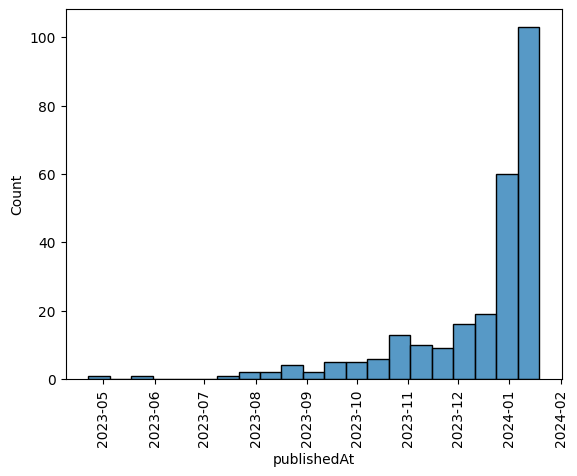

In [23]:
sns.histplot(data=data_clean, x="publishedAt", palette="mako")
plt.xticks(rotation=90);

In [24]:
dates = pd.DataFrame(data_clean["publishedAt"].value_counts().sort_values(ascending=False)).reset_index().rename(columns={"index":"publish date","publishedAt":"count"})
# dates = pd.DataFrame(data_clean["publishedAt"].value_counts().sort_values(ascending=False))
dates

,publish date,count
0,2024-01-05,23
1,2024-01-10,18
2,2024-01-18,15
3,2024-01-11,14
4,2024-01-19,13
...,...,...
72,2023-12-11,1
73,2023-10-25,1
74,2023-12-19,1
75,2023-10-21,1


In [25]:
dates["publish date"] = pd.to_datetime(dates["publish date"])

In [26]:
# plt.hist(x=dates["publish date"], y= dates["count"])

''

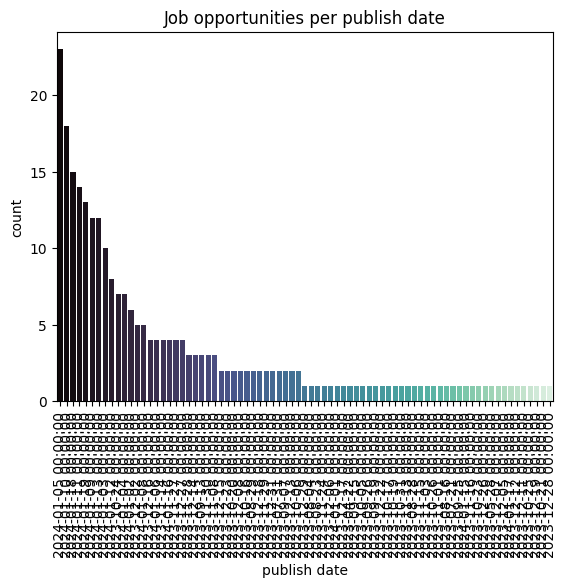

In [27]:
import matplotlib.dates as mdates

# TO DO : graph regroupé par mois
ax = plt.axes()
# ax.plot(dates["publish date"], dates["count"])
sns.barplot(data=dates, x="publish date",y="count", palette="mako", ax=ax)
ax.set_xticklabels(dates["publish date"], rotation=90)
ax.set_title("Job opportunities per publish date")
# fmt = mdates.DateFormatter('%m/%Y')
# ax.xaxis.set_major_formatter(fmt)
;

In [28]:
# plt.plot(x=dates["publish date"], y=dates["count"])

In [29]:
sector_top_10 = pd.DataFrame(data_clean["sector"].value_counts().sort_values(ascending=False).head(10)).reset_index().rename(columns={"index":"sector","sector":"count"})
sector_top_10
# sns.histplot(data=sector_top_10, x=)

,sector,count
0,"Technology, Information and Internet",48
1,Software Development,43
2,Financial Services,32
3,IT Services and IT Consulting,24
4,Human Resources Services,20
5,"Transportation, Logistics, Supply Chain and St...",11
6,Staffing and Recruiting,9
7,Computer and Network Security,5
8,Human Resources,4
9,"Software Development and Technology, Informati...",4


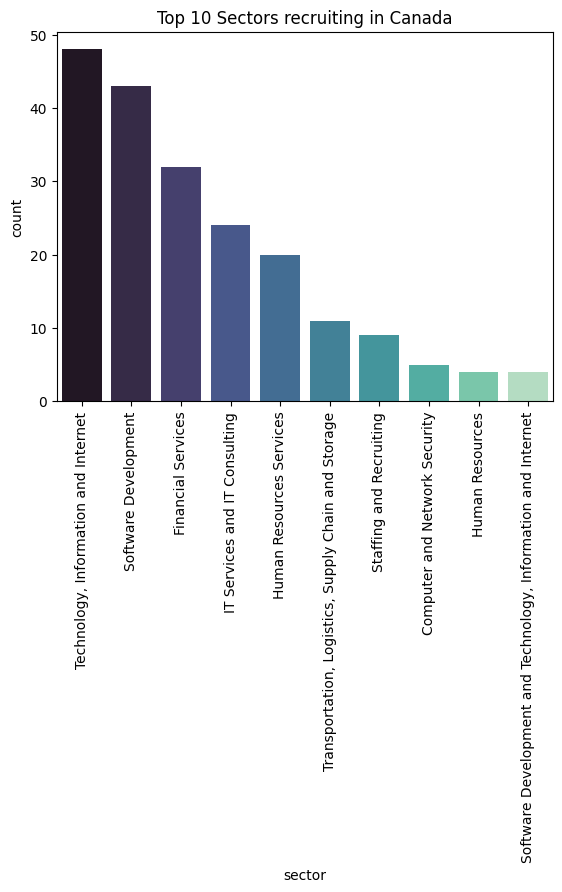

In [64]:
sns.barplot(data=sector_top_10, x="sector",y="count", palette="mako")
plt.xticks(rotation=90)
plt.title("Top 10 Sectors recruiting in Canada");

In [31]:
data_clean.sort_values(ascending=False, by="sector")

,applicationsCount,companyId,companyName,contractType,description,experienceLevel,postedTime,publishedAt,sector,title,workType,city
224,151 applicants,4781.0,Warner Music Group,Full-time,"At Warner Music Group, we’re a global collecti...",Not Applicable,2 weeks ago,2024-01-02,"Transportation, Logistics, Supply Chain and St...",Software Quality Engineer,Engineering and Information Technology,Toronto
6,61 applicants,10917972.0,RouteThis,Full-time,RouteThis is a Waterloo-based B2B SaaS whose t...,Not Applicable,1 week ago,2024-01-12,"Transportation, Logistics, Supply Chain and St...",Machine Learning Developer,Engineering and Information Technology,Toronto
75,Over 200 applicants,3717375.0,Quincus,Full-time,“Make every logistics journey your best one ye...,Not Applicable,9 months ago,2023-04-22,"Transportation, Logistics, Supply Chain and St...",Machine Learning Engineer,Engineering and Information Technology,Toronto
197,Over 200 applicants,25031175.0,Maple (getmaple.ca),Full-time,"About Maple\n\nFounded in 2015, Maple is a fas...",Not Applicable,1 month ago,2023-12-11,"Transportation, Logistics, Supply Chain and St...",Senior Software Engineer (Front End),Engineering and Information Technology,Toronto
217,64 applicants,10865494.0,Super.com,Internship,About Super.com\n\nWe started Super.com to hel...,Not Applicable,3 months ago,2023-10-16,"Transportation, Logistics, Supply Chain and St...",Senior Software Engineer - Internal Tools (Rem...,Engineering and Information Technology,Toronto
...,...,...,...,...,...,...,...,...,...,...,...,...
226,Over 200 applicants,68940167.0,Peggy,Full-time,Senior Mobile Developer - Flutter/Dart\n\nAbou...,Mid-Senior level,5 months ago,2023-08-16,Artists and Writers,Senior Mobile Developer,Engineering and Information Technology,Toronto
110,Over 200 applicants,507067.0,Flipp,Full-time,Flipp is a pre-IPO company on a mission to hel...,Entry level,2 weeks ago,2024-01-04,"Advertising Services, Software Development, an...",Software Engineering Associate,Engineering and Information Technology,Canada
9,Over 200 applicants,507067.0,Flipp,Full-time,Work term commitment: 12-16 months for Spring ...,Mid-Senior level,2 weeks ago,2024-01-06,"Advertising Services, Software Development, an...",Machine Learning Scientist Associate,Other,Canada
192,196 applicants,31517.0,Yelp,Full-time,Summary\n\nYelp engineering culture is driven ...,Mid-Senior level,1 week ago,2024-01-11,"Advertising Services, Software Development, an...",Senior Machine Learning Engineer (Remote - Can...,Engineering,Vancouver


In [32]:
experiencelevel = data_clean.experienceLevel.value_counts()
experiencelevel = pd.DataFrame(experiencelevel)
experiencelevel=experiencelevel.reset_index()
experiencelevel

,index,experienceLevel
0,Mid-Senior level,146
1,Entry level,60
2,Not Applicable,31
3,Associate,19
4,Internship,3


Text(0.5, 1.0, 'Job Search Queries by Experience Level')

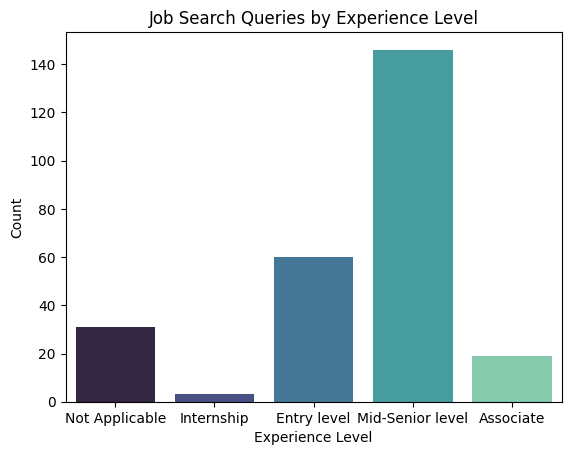

In [63]:
# Distribution of job by experience level

# Define order of experience level
experience_order="Not Applicable", "Internship","Entry level","Mid-Senior level","Associate"

# Visualisation
sns.barplot(data=experiencelevel, x="index", y="experienceLevel", order=experience_order, palette="mako")
plt.xlabel("Experience Level")
plt.ylabel("Count")
plt.title("Job Search Queries by Experience Level")

In [34]:
data_clean["description"].str.len().max()

12360

In [35]:
title = pd.DataFrame(data_clean.title.value_counts()).reset_index()

title

,index,title
0,"Machine Learning Engineer I, ML (Anywhere ML)",15
1,"Machine Learning Engineer II, ML (Credit Decis...",8
2,Python Engineer,7
3,Senior Machine Learning Engineer,6
4,"Senior Software Developer, Machine Learning (1...",5
...,...,...
196,Python Developer,1
197,Ruby Developer,1
198,Senior Full-Stack Developer (Remote - anywhere...,1
199,Tech Lead/Full stack Developer-Canada,1


In [36]:
# Positionner les points sur une carte
# -> nécessite d'avoir correspondance entre ville et lat/lon

In [37]:
contract_type = pd.DataFrame(data_clean.contractType.value_counts()).reset_index().rename(columns={"index":"Contract_Type", "contractType":"count"})
contract_type

,Contract_Type,count
0,Full-time,230
1,Contract,24
2,Part-time,4
3,Internship,1


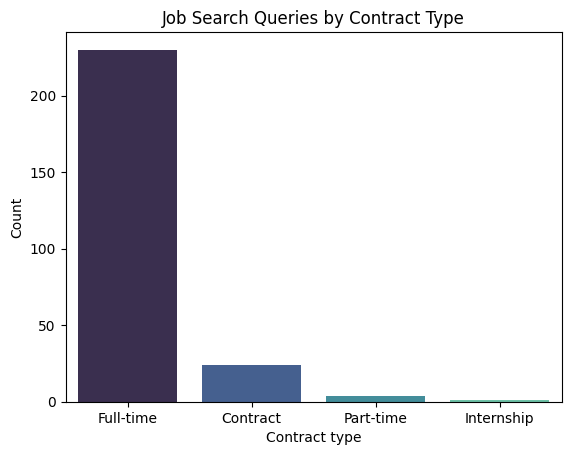

In [66]:
# Distribution of job by contract type

# Define order of contract type
contract_type_order ="Full-time", "Contract","Part-time","Internship"

# Visualisation
sns.barplot(data=contract_type, y="count", x="Contract_Type", order=contract_type_order, palette="mako")
plt.xlabel("Contract type")
plt.ylabel("Count")
plt.title("Job Search Queries by Contract Type");

In [39]:
# Top 10 company hiring

Top_10_hiring_company = pd.DataFrame(data_clean.companyName.value_counts().head(10)).reset_index().rename(columns={"index":"Company", "companyName":"count"})
Top_10_hiring_company

,Company,count
0,Affirm,24
1,Zortech Solutions,17
2,Canonical,13
3,Techedin,11
4,Kinaxis,7
5,Braintrust,5
6,Hour Consulting,5
7,Software International,4
8,Quora,4
9,Okta,3


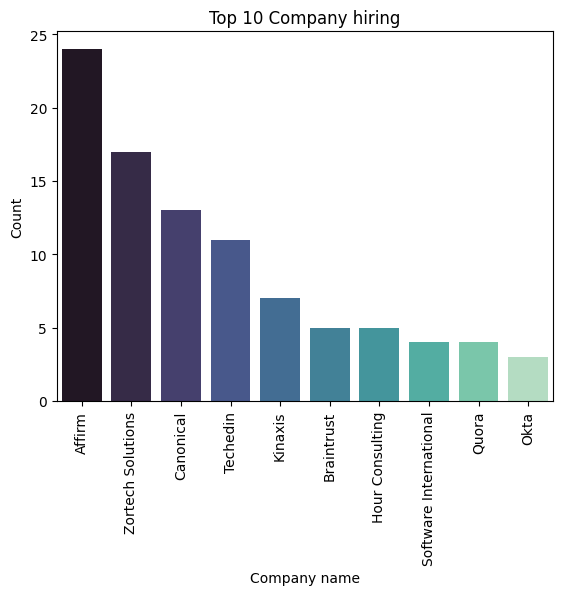

In [40]:

# Visualisation
sns.barplot(data=Top_10_hiring_company, y="count", x="Company", palette="mako")
plt.xlabel("Company name")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Top 10 Company hiring");

# Most popular words in job description

In [41]:
# TO DO : Transformer pour traduire les descriptions français en anglais.


In [42]:
# TO DO : description de fonction

# Preprocessing function for description column
def preprocessing(sentence):
    """mettre une description de fonction """

    # Removing whitespaces
    sentence = sentence.strip()

    # Removing /n
    sentence = sentence.strip("/n")

    # Lowercasing
    sentence = sentence.lower()

    # Removing numbers
    sentence = ''.join(char for char in sentence if not char.isdigit())

    # Removing punctuation
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '')
    sentence = sentence.replace("’","")

    # Tokenizing
    tokenized_sentence = word_tokenize(sentence)

    # define stopwords
    stop_words = set(stopwords.words('english'))

    # remove stopwords
    tokenized_sentence_cleaned = [word for word in tokenized_sentence if not word in stop_words]

    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokenized_sentence_cleaned]
    # sentence = " ".join(lemmatized)

    # return sentence
    return lemmatized

In [43]:
data_clean['description_clean'] = data.description.apply(preprocessing)


In [44]:
# Identification of top 20 words from all the job description

# Creation of a corpus with all preprocessed job description
corpus = data_clean.description_clean.apply(pd.Series).stack().reset_index(drop=True)

# Identification of top 20 words from this corpus
allWordDist = FreqDist(corpus)

# Displaying in correct format
test = pd.DataFrame(allWordDist.most_common(15)).rename(columns={0:"keyword",1:"count"})
test

,keyword,count
0,experience,1386
1,team,1220
2,data,984
3,work,914
4,learning,679
5,product,575
6,machine,517
7,software,513
8,model,493
9,role,492


# Top popular job title

In [45]:
data_clean

,applicationsCount,companyId,companyName,contractType,description,experienceLevel,postedTime,publishedAt,sector,title,workType,city,description_clean
0,Over 200 applicants,11000395.0,Embarq,Full-time,About Embarq\n\nWe help VC-backed US startups ...,Mid-Senior level,2 weeks ago,2024-01-05,IT Services and IT Consulting and Software Dev...,Machine Learning Engineer,Engineering and Information Technology,Quebec,"[embarq, help, vcbacked, u, startup, build, so..."
1,Over 200 applicants,912833.0,Thumbtack,Full-time,A home is the biggest investment most people m...,Not Applicable,2 weeks ago,2024-01-05,"Technology, Information and Internet","Data Scientist, Business Analytics",Engineering and Information Technology,Ontario,"[home, biggest, investment, people, make, yet,..."
2,Over 200 applicants,10064814.0,Clarifai,Full-time,"About The Company\n\nClarifai is a leading, fu...",Mid-Senior level,4 months ago,2023-09-15,"Technology, Information and Internet",Data Scientist,Engineering and Information Technology,Montreal,"[company, clarifai, leading, fulllifecycle, de..."
3,Over 200 applicants,6637598.0,Drop,Full-time,"As a member of the Data Science team, you are ...",Not Applicable,2 months ago,2023-11-15,"Transportation, Logistics, Supply Chain and St...","Data Science, Investment Research",Engineering and Information Technology,Toronto,"[member, data, science, team, responsible, lev..."
4,Over 200 applicants,2681218.0,Logikk,Full-time,Data Scientist - Computer Vision Tech Company ...,Mid-Senior level,2 weeks ago,2024-01-05,IT Services and IT Consulting,Data Scientist,Engineering,Montreal,"[data, scientist, computer, vision, tech, comp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,98 applicants,926041.0,Okta,Full-time,Get to know Okta\n\nOkta is The World’s Identi...,Not Applicable,1 week ago,2024-01-10,"IT Services and IT Consulting, Software Develo...",Observability Engineer,Engineering and Information Technology,Canada,"[affirm, reinventing, credit, make, honest, fr..."
255,Over 200 applicants,5045143.0,StackAdapt,Full-time,StackAdapt is a self-serve advertising platfor...,Entry level,1 week ago,2024-01-11,"Technology, Information and Internet","Software Engineer, Backend (Intermediate/Senior)",Engineering and Information Technology,Canada,"[description, based, oxford, office, canada, u..."
256,45 applicants,14051.0,Kinaxis,Full-time,About Kinaxis\n\nKinaxis is the global leader ...,Internship,1 week ago,2024-01-13,Software Development,"Co-Op/Intern Developer, DevOps",Engineering and Information Technology,Québec,"[affirm, reinventing, credit, make, honest, fr..."
257,Over 200 applicants,93075952.0,Saks,Full-time,Who We Are:\n\nSaks Cloud Services (SCS) is an...,Associate,2 weeks ago,2024-01-04,Software Development,Atlassian Systems Engineer,Information Technology,Canada,"[building, rich, heritage, zinnia, transformin..."


In [46]:
data_clean['title_clean'] = data.title.apply(preprocessing)


In [47]:
# Identification of top 20 words from all the job description

# Creation of a corpus with all preprocessed job description
corpus = data_clean.title_clean.apply(pd.Series).stack().reset_index(drop=True)

# Identification of top 20 words from this corpus
allWordDist = FreqDist(corpus)

# Displaying in correct format
test = pd.DataFrame(allWordDist.most_common(15)).rename(columns={0:"keyword",1:"count"})
test

,keyword,count
0,engineer,141
1,machine,72
2,learning,71
3,senior,62
4,developer,61
5,software,60
6,remote,43
7,ml,42
8,data,39
9,scientist,31


# Mapping job opportunities across Canada

In [48]:
# Define a city list without any duplicates
city = data_clean.city
city.drop_duplicates(inplace=True)

In [49]:
city_name = []
latitude = []
longitude = []

for city in data_clean.city:
    loc = Nominatim(user_agent="Geopy Library")
    getLoc=loc.geocode(f"{city}")
    # print(f"name : {city}")
    city_name.append(city)
    latitude.append(getLoc.latitude)
    longitude.append(getLoc.longitude)
    # print(f"latitude : {getLoc.latitude}")
    # print(f"longitude : {getLoc.longitude}")
latitude

[52.4760892,
 50.000678,
 45.5031824,
 43.6534817,
 45.5031824,
 61.0666922,
 43.6534817,
 46.097995,
 44.3893208,
 61.0666922,
 61.0666922,
 61.0666922,
 61.0666922,
 61.0666922,
 61.0666922,
 50.000678,
 45.5031824,
 61.0666922,
 43.8975558,
 61.0666922,
 61.0666922,
 50.000678,
 47.5614705,
 61.0666922,
 43.6534817,
 45.4208777,
 43.451291,
 61.0666922,
 53.5462055,
 61.0666922,
 50.000678,
 49.8879177,
 61.0666922,
 43.6534817,
 61.0666922,
 61.0666922,
 61.0666922,
 49.2608724,
 50.000678,
 52.131802,
 53.5462055,
 52.4760892,
 61.0666922,
 61.0666922,
 61.0666922,
 61.0666922,
 43.6534817,
 61.0666922,
 43.6534817,
 55.001251,
 61.0666922,
 61.0666922,
 61.0666922,
 49.8955367,
 61.0666922,
 43.6534817,
 43.7146484,
 61.0666922,
 61.0666922,
 61.0666922,
 61.0666922,
 61.0666922,
 61.0666922,
 43.6534817,
 61.0666922,
 61.0666922,
 61.0666922,
 43.6534817,
 61.0666922,
 61.0666922,
 61.0666922,
 45.5031824,
 43.6534817,
 43.6534817,
 43.6534817,
 43.6534817,
 61.0666922,
 61.0666

In [50]:
gps_coordinate = pd.DataFrame(latitude, index = city_name, columns=["latitude"]).reset_index()

In [51]:
gps_coordinate["longitude"] = longitude
gps_coordinate = gps_coordinate.rename(columns={"index":"city"})
gps_coordinate

,city,latitude,longitude
0,Quebec,52.476089,-71.825867
1,Ontario,50.000678,-86.000977
2,Montreal,45.503182,-73.569806
3,Toronto,43.653482,-79.383935
4,Montreal,45.503182,-73.569806
...,...,...,...
254,Canada,61.066692,-107.991707
255,Canada,61.066692,-107.991707
256,Québec,52.476089,-71.825867
257,Canada,61.066692,-107.991707


In [52]:
# Check if no null values
data_clean.isnull().sum().sort_values(ascending=False)/len(data_clean)

applicationsCount    0.0
companyId            0.0
companyName          0.0
contractType         0.0
description          0.0
experienceLevel      0.0
postedTime           0.0
publishedAt          0.0
sector               0.0
title                0.0
workType             0.0
city                 0.0
description_clean    0.0
title_clean          0.0
dtype: float64

In [53]:
# Correspondance entre les

data_clean = data_clean.merge(gps_coordinate)

In [54]:
# no null values
data_clean.isnull().sum().sort_values(ascending=False)/len(data_clean)

applicationsCount    0.0
companyId            0.0
companyName          0.0
contractType         0.0
description          0.0
experienceLevel      0.0
postedTime           0.0
publishedAt          0.0
sector               0.0
title                0.0
workType             0.0
city                 0.0
description_clean    0.0
title_clean          0.0
latitude             0.0
longitude            0.0
dtype: float64

In [55]:
city_count = data_clean[["city","longitude", "latitude"]].value_counts().reset_index().rename(columns={0:"count"}).sort_values(by="count",ascending=False)
city_count

,city,longitude,latitude,count
0,Canada,-107.991707,61.066692,16129
1,Toronto,-79.383935,43.653482,1764
2,Vancouver,-123.113952,49.260872,225
3,Ontario,-86.000977,50.000678,64
4,Montreal,-73.569806,45.503182,64
5,Hamilton,-79.872858,43.256080,16
6,Victoria,144.678005,-36.598610,16
7,Ottawa,-75.690111,45.420878,16
8,Winnipeg,-97.138458,49.895537,16
9,Calgary,-114.057541,51.045606,16


In [56]:
city_count_without_canada = city_count.drop(index=[0])

In [57]:
# Remove Canada values and replace values that are excentric to canada -> there are just errors from search

# Windsor -> correct lat / lon : Latitude	42.314937	Longitude	-83.036363
# Laval -> -73.707092, 45.612499
# London -> -81.249725, 42.983612
# Victoria -> -123.329773, 48.407326
# Waterloo -> -80.520410, 43.464258
# Queens -> -76.495099, 44.224997

In [58]:
city_count_without_canada = city_count_without_canada.set_index("city")

In [59]:
# Replacing gps coordinates for the following cities
city_count_without_canada.loc["Windsor",["longitude","latitude"]]=[-83.036363,42.314937]
city_count_without_canada.loc["Laval",["longitude","latitude"]]=[-73.707092,45.612499]
city_count_without_canada.loc["London",["longitude","latitude"]]=[-81.249725,42.983612]
city_count_without_canada.loc["Victoria",["longitude","latitude"]]=[-123.329773,48.407326]
city_count_without_canada.loc["Waterloo",["longitude","latitude"]]=[-80.520410,43.464258]
city_count_without_canada.loc["Queens",["longitude","latitude"]]=[-76.495099,44.224997]
city_count_without_canada


,longitude,latitude,count
city,,,
Toronto,-79.383935,43.653482,1764
Vancouver,-123.113952,49.260872,225
Ontario,-86.000977,50.000678,64
Montreal,-73.569806,45.503182,64
Hamilton,-79.872858,43.256080,16
Victoria,-123.329773,48.407326,16
Ottawa,-75.690111,45.420878,16
Winnipeg,-97.138458,49.895537,16
Calgary,-114.057541,51.045606,16


In [79]:
# Mapping all job opportunities on Canada map

# Folium

map = folium.Map(location=[45.420878,-79.690111], zoom_start = 4.4)
lat_long= [[lat, long] for lat, long in zip(city_count_without_canada['latitude'][:100], city_count_without_canada['longitude'][:100])]
crime_heat_map = HeatMap(lat_long)
crime_heat_map.add_to(map)
map